# BM40A1401 GPU Computing

## Erik Kuitunen

### Exercise 4

#### Task 1 
Sparse matrices

##### a)
Compare the memory footprint of matrices in dense, COO and CSR -formats. Plot the amount of stored elements against the total number of elements in the matrix. Use sparse matrices with density of 0.01. Use different square matrix sizes to show the difference.

Hint: For COO and CSR formats you will have to find the sizes of vectors they store the data. Check out CuPy Sparse reference.

In [142]:
# Importing necessary libraries
import cupyx as cpx
import numpy as np
import cupy as cp

from matplotlib import pyplot as plt 

In [143]:

matrix_sizes = 2**np.array( range( 3, 12, 1 ) )

A_coo_sizes = []
A_csr_sizes = []
A_dense_sizes = []

for sz in matrix_sizes:
    
    # Creating sparse matrix and converting it to required formats
    A_coo = cpx.scipy.sparse.rand( int( sz ), int( sz ) )
    A_dense = A_coo.todense()  
    A_csr = cpx.scipy.sparse.csr_matrix( A_coo )
    
    # Calculate memory footprint
    A_dense_sizes.append( A_dense.size )
    A_coo_sizes.append( A_coo.data.size + A_coo.row.size + A_coo.col.size)
    A_csr_sizes.append( A_csr.data.size + A_csr.indices.size + A_csr.indptr.size )

Visualizing results

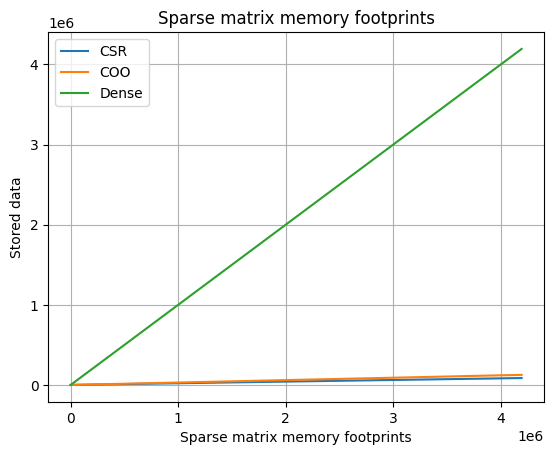

In [144]:
plt.plot( matrix_sizes**2, A_csr_sizes, label = "CSR" )
plt.plot( matrix_sizes**2, A_coo_sizes, label = "COO" ) 
plt.plot( matrix_sizes**2, A_dense_sizes, label = "Dense" ) 

plt.grid()
plt.legend()
plt.title( "Sparse matrix memory footprints" )
plt.xlabel( "Sparse matrix memory footprints" )
plt.ylabel( "Stored data" )

plt.show()

##### b)

Compare the execution times of dot products between a matrix and a vector. Use four different cases for the matrix: Scipy dense, Scipy COO, CuPy dense and CuPy COO. The vector should be in dense-format in all cases.

Time their performance against different sizes of square matrices.

In [145]:
import scipy as sc 
import time

matrix_sizes = 2**np.array( range( 3, 15, 1 ) )

# Initalizing result variable
times_sci_coo = np.zeros( ( matrix_sizes.size, 1) )
times_sci_dense = np.zeros( ( matrix_sizes.size, 1) )
times_cupy_coo = np.zeros( ( matrix_sizes.size, 1) )
times_cupy_dense = np.zeros( ( matrix_sizes.size, 1) )

# Using the same matrix sizes as in a)
ii = 0
for sz in matrix_sizes:
    
    # Creating vector and desired matrices
    vector = np.random.randn( int(sz), 1 )
    
    A_sci_coo = sc.sparse.rand( int(sz), int(sz) )
    A_sci_dense = A_sci_coo.todense()
    
    A_cupy_coo = cpx.scipy.sparse.rand( int(sz), int(sz) )
    A_cupy_dense = A_cupy_coo.todense()
    
    # Measuring execution times
    
    # First SciPy COO and SciPy dense
    start_time = time.perf_counter()
    result = A_sci_coo.dot( vector )
    end_time = time.perf_counter()
    
    times_sci_coo[ii, 0] = ( end_time - start_time ) * 1000
    
    start_time = time.perf_counter()
    result = A_sci_dense.dot( vector )
    end_time = time.perf_counter()
    
    times_sci_dense[ii, 0] = ( end_time - start_time ) * 1000
    
    # Then CuPy COO and CuPy dense
    vector = cp.array( vector )
    
    start_time = time.perf_counter()
    result = A_cupy_coo.dot( vector )
    end_time = time.perf_counter()
    
    times_cupy_coo[ii, 0] = ( end_time - start_time ) * 1000
    
    start_time = time.perf_counter()
    result = cp.dot( A_cupy_dense, vector )
    end_time = time.perf_counter()
    
    times_cupy_dense[ii, 0] = ( end_time - start_time ) * 1000
    
    ii += 1
    

Visualizing results

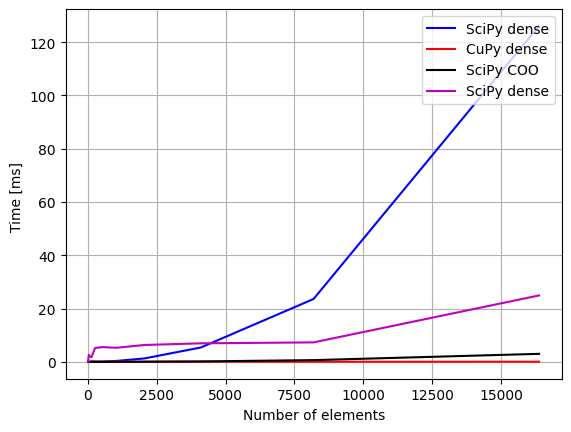

In [146]:
plt.plot( matrix_sizes, times_sci_dense, 'b', label = "SciPy dense")
plt.plot( matrix_sizes, times_cupy_dense, 'r', label = "CuPy dense")
plt.plot( matrix_sizes, times_sci_coo, 'k', label = "SciPy COO")
plt.plot( matrix_sizes, times_cupy_coo, 'm', label = "SciPy dense")

plt.xlabel( 'Number of elements')
plt.ylabel( 'Time [ms] ') 
plt.legend( loc = "upper right" )
plt.grid()


plt.show()

#### Task 2
Random numbers

Estimate the value of pi by random sampling. Implement by using both CuPy and Numpy and compare the execution time with million random points.


In [147]:
N = 1e6

First using NumPy

In [148]:
start_time = time.perf_counter()

distances = np.zeros( ( int(N), 1 ) )
samples = np.random.rand( int(N), 2 ) - 0.5


# Looping through the samples
index = 0
while index < N:
    distances[ index ] = samples[ index, 0 ] ** 2 + samples[ index, 1] ** 2
    index += 1
inside_circle = sum( distances <= 0.5 ** 2 )

pi_approx_cpu = inside_circle / N * 4

end_time = time.perf_counter()

time_cpu = ( end_time - start_time ) * 1000


Then with CuPy

In [153]:
start_time = time.perf_counter()

samples = cp.random.rand( int(N), 2 ) - 0.5 

distances = cp.dot( cp.square( samples ), cp.array( [ [1], [1] ] ) )

inside_circle = sum( cp.less_equal( distances, 0.5**2) )

pi_approx_gpu = inside_circle / N * 4

end_time = time.perf_counter()

time_gpu = ( end_time - start_time ) * 1000

Results

In [150]:
print( "Time for CPU was %f seconds and result was %f. Time for GPU was %f seconds and result was %f." 
       % (time_cpu, pi_approx_cpu, time_gpu, pi_approx_gpu ))

Time for CPU was -5.896500 seconds and result was 3.141292. Time for GPU was 337993.955100 seconds and time was 3.141952.


C:\Users\erikk\AppData\Local\Temp\ipykernel_26952\2442953866.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( "Time for CPU was %f seconds and result was %f. Time for GPU was %f seconds and time was %f."
